In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.collections as mc

from pprint import pprint

from plot import *
from building import *
from config import *
from generator import *
from db_utils import *
from scanner import *
from misc_utils import *

### Assumptions

1. Every edge for every building is divided into subparts if the length is very large. For example, a stadium's edge even though it is straight, will be divided into multiple edges to make sure the edge is detected in the scanner. This is required as the scanner's range is restricted. Doing this has no performance hit as the bottleneck is the number of features in edge, so the splitting has no performance hit on ***this*** algorithm.
2. Buildings are convex. If not, split the building into convex parts and the overlapping edges with no feature points

### Algorithm

- Tag all nodes, edges based on FOV
- Find all the buildings that are there in the given FOV
    - A building is visible if either the edge is tagged in FOV or the vertex is tagged in FOV
- For all buildings get the frontier set of edges based on the ORIGIN
- Valid edges are current all edges that are tagged in FOV as well as in the frontier.
- Remove edges from this set that are overshadowed
- Calculate the effective scope of each building
- For every building scope, remove edges that are overshadowed by this scope

In [2]:
if ORIGINAL_DATA:
    points = read_points()
    edges = read_edges(points)
else:
    points = generate_data(NPOINTS)
    edges = get_edges()

print_util(points, "points")
print_util(edges, "edges")

edges_mat = get_adj_mat(points, edges)
print_util(edges_mat, "edges_mat")

edges_list = get_adj_list(points, edges)
print_util(edges_list, "edges_list")

points
      x     y      color
0  1.37  5.82  lightblue
1  8.67  8.21  lightblue
2  7.82  0.64  lightblue
3  2.61  1.20  lightblue
4  5.07  7.79  lightblue
5  4.60  4.83  lightblue
6  6.67  3.88  lightblue
7  8.07  2.14  lightblue
8  0.96  4.99  lightblue
9  0.29  9.14  lightblue

edges
   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5  lightblue
3      4    1  lightblue
4      6    5  lightblue
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue

edges_mat
[[-1, -1, -1, -1, -1, -1, -1, -1, 1, 0],
 [-1, -1, -1, -1, 3, -1, 5, -1, -1, -1],
 [-1, -1, -1, 6, -1, -1, -1, 7, -1, -1],
 [-1, -1, 6, -1, -1, -1, -1, -1, -1, -1],
 [-1, 3, -1, -1, -1, 2, -1, -1, -1, -1],
 [-1, -1, -1, -1, 2, -1, 4, -1, -1, -1],
 [-1, 5, -1, -1, -1, 4, -1, -1, -1, -1],
 [-1, -1, 7, -1, -1, -1, -1, -1, -1, -1],
 [1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [0, -1, -1, -1, -1, -1, -1, -1, -1, -1]]

edges_list
[[[9, 0], [8, 1]],
 [[4, 3], [6, 5]],
 [[3, 6], [

In [3]:
base_angle = get_angle(DIRECTION)

viewpoint = add_vector_to_point(ORIGIN, DIRECTION, RADIUS)

viewpoint_begin = rotate_point(viewpoint, ORIGIN, FOV/2)
viewpoint_end = rotate_point(viewpoint, ORIGIN, -FOV/2)

axis_xp = rotate_point(viewpoint, ORIGIN, -90)
axis_xn = rotate_point(viewpoint, ORIGIN, 90)

print("base_angle ", base_angle)
print("viewpoint ", viewpoint)
print("viewpoint_begin ", viewpoint_begin)
print("viewpoint_end ", viewpoint_end)
print("axis_xp ", axis_xp)
print("axis_xn ", axis_xn)

base_angle  45.00000000000001
viewpoint  [8.596194077712559, 8.596194077712559]
viewpoint_begin  [5.128713154835047, 10.401250394579352]
viewpoint_end  [10.401250394579352, 5.128713154835047]
axis_xp  [8.596194077712559, -0.5961940777125587]
axis_xn  [-0.5961940777125587, 8.596194077712559]


In [4]:
tag_points_fov(points)
print_util(points, "points")

reference_angle :  45.00000000000001
semicircle_angle_start :  -44.99999999999999
semicircle_angle_end:  135.0
fov_angle_start:  10.000000000000007
fov_angle_end:  80.0
points
      x     y      color  normalized_angle
0  1.37  5.82  lightblue        190.316176
1  8.67  8.21      black         87.034626
2  7.82  0.64    crimson        363.665750
3  2.61  1.20  lightblue        288.598885
4  5.07  7.79      black        119.234465
5  4.60  4.83      black         99.137151
6  6.67  3.88    crimson        402.426641
7  8.07  2.14    crimson        380.439483
8  0.96  4.99  lightblue        206.961752
9  0.29  9.14    fuchsia        170.821370



In [5]:
tag_edges_fov(points, edges)
print_util(edges)

   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5      black
3      4    1      black
4      6    5      black
5      6    1      black
6      2    3  lightblue
7      2    7  lightblue



In [6]:
id_to_build_map, buildings = get_building_set(points, edges_list)
print_util(id_to_build_map, "id_to_build_map")
print_util(buildings, "buildings")

in  1
total  [1, 4, 6, 5]
in  2
total  [2, 3, 7]
in  9
total  [9, 0, 8]
id_to_build_map
{0: 2, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 2, 9: 2}

buildings
{0: [1, 4, 6, 5], 1: [2, 3, 7], 2: [9, 0, 8]}



In [7]:
spans = get_spans(points, edges, edges_list, buildings)
print_util(spans, "spans")

[[1.0241581909060726, 99.13715101413874, 5, 4.6, 4.83],
 [2.6726952688250862, 402.4266405368232, 6, 6.67, 3.88],
 [3.9381467722775394, 119.23446469265346, 4, 5.07, 7.79],
 [6.287527335924672, 87.03462594481084, 1, 8.67, 8.21]]

in  [1.0241581909060726, 99.13715101413874, 5, 4.6, 4.83]
4   2   99.13715101413874   99.13715101413874
4   2   99.13715101413874   119.23446469265346
6   4   99.13715101413874   119.23446469265346
6   4   99.13715101413874   402.4266405368232
in  [2.6726952688250862, 402.4266405368232, 6, 6.67, 3.88]
1   5   99.13715101413874   402.4266405368232
1   5   87.03462594481084   402.4266405368232
in  [3.9381467722775394, 119.23446469265346, 4, 5.07, 7.79]
1   3   87.03462594481084   402.4266405368232
1   3   87.03462594481084   402.4266405368232
in  [6.287527335924672, 87.03462594481084, 1, 8.67, 8.21]
building 
0

valid
[2, 4, 5]

invalid
[3]

span
[1, 6]

[[3.1260358283295475, 288.5988847976303, 3, 2.61, 1.2],
 [4.4748742999105575, 380.4394828550279, 7, 8.07, 2.14]

In [8]:
remove_overshadowing_edges(points, edges)
print_util(edges, "edges after overshadow filter")

[99.13715101413874, 402.4266405368232]   [99.13715101413874, 119.23446469265346]   True
1.0241581909060726   1.0241581909060726   True
4  overlaps  2
[99.13715101413874, 119.23446469265346]   [99.13715101413874, 402.4266405368232]   False
1.0241581909060726   1.0241581909060726   True
[87.03462594481084, 402.4266405368232]   [99.13715101413874, 402.4266405368232]   True
2.6726952688250862   1.0241581909060726   False
[99.13715101413874, 119.23446469265346]   [87.03462594481084, 402.4266405368232]   False
1.0241581909060726   2.6726952688250862   True
[99.13715101413874, 402.4266405368232]   [87.03462594481084, 402.4266405368232]   False
1.0241581909060726   2.6726952688250862   True
edges after overshadow filter
   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5  lightblue
3      4    1  lightblue
4      6    5      black
5      6    1      black
6      2    3  lightblue
7      2    7  lightblue



In [9]:
remove_overshadowing_edges_spans(points, edges, spans)
print_util(edges, "edges after spanned overshadow filter")

[99.13715101413874, 402.4266405368232]   [87.03462594481084, 402.4266405368232]   False
1.0241581909060726   2.6726952688250862   True
[87.03462594481084, 402.4266405368232]   [87.03462594481084, 402.4266405368232]   True
2.6726952688250862   2.6726952688250862   True
5  overlaps  5
[99.13715101413874, 402.4266405368232]   [288.5988847976303, 380.4394828550279]   True
1.0241581909060726   3.1260358283295475   True
4  overlaps  4
[99.13715101413874, 402.4266405368232]   [170.82136996231506, 206.96175152102745]   True
1.0241581909060726   3.1971393463532363   True
4  overlaps  4
edges after spanned overshadow filter
   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5  lightblue
3      4    1  lightblue
4      6    5  lightblue
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue



      x     y      color  normalized_angle
0  1.37  5.82  lightblue        190.316176
1  8.67  8.21      black         87.034626
2  7.82  0.64    crimson        363.665750
3  2.61  1.20  lightblue        288.598885
4  5.07  7.79      black        119.234465
5  4.60  4.83      black         99.137151
6  6.67  3.88    crimson        402.426641
7  8.07  2.14    crimson        380.439483
8  0.96  4.99  lightblue        206.961752
9  0.29  9.14    fuchsia        170.821370

   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5  lightblue
3      4    1  lightblue
4      6    5  lightblue
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue



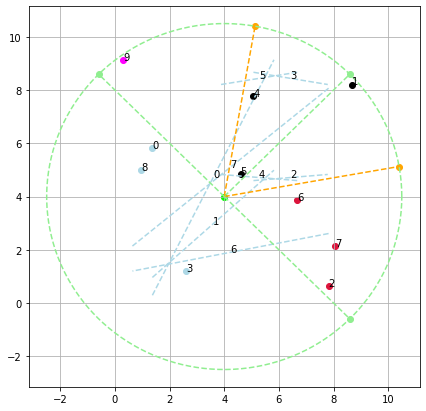

In [10]:
plot_situation(points, edges, viewpoint, viewpoint_begin, viewpoint_end, axis_xp, axis_xn)

In [11]:
points

,x,y,color,normalized_angle
0,1.37,5.82,lightblue,190.316176
1,8.67,8.21,black,87.034626
2,7.82,0.64,crimson,363.665750
3,2.61,1.20,lightblue,288.598885
4,5.07,7.79,black,119.234465
5,4.60,4.83,black,99.137151
6,6.67,3.88,crimson,402.426641
7,8.07,2.14,crimson,380.439483
8,0.96,4.99,lightblue,206.961752
9,0.29,9.14,fuchsia,170.821370


In [12]:
edges

,start,end,color
0,0,9,lightblue
1,0,8,lightblue
2,4,5,lightblue
3,4,1,lightblue
4,6,5,lightblue
5,6,1,lightblue
6,2,3,lightblue
7,2,7,lightblue
